In [ ]:
# Data Processor
import pandas
import nltk
from nltk.corpus import stopwords
from sklearn import model_selection, preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt

nltk.download('stopwords')

STOPSET_WORDS = ['might', 'may', 'would', 'must', 'lgtm', 'could', 'can', 'good', 'great', 'nice', 'well',\
                 'better', 'worse', 'worst', 'should', 'i', "i'll", "ill", "it's", "its", "im", "i'm", \
                 "they're", "theyre", "you're", "youre", "that's", 'btw', "thats", "theres", "shouldnt", \
                 "shouldn't", "didn't", "didnt", "dont", "don't", "doesn't", "doesnt", "wasnt", "wasn't", \
                 'sense', "mon", 'monday', 'tue', 'wed', 'wednesday', 'thursday', 'thu', 'friday', 'fri', \
                 'sat', 'saturday', 'sun', 'sunday', 'jan', 'january', 'feb', 'february', 'mar', 'march', \
                 'apr', 'april', 'may', 'jun', 'june', 'july', 'jul', 'aug', 'august','sep', 'september', \
                 'oct', 'october', 'nov', 'novenber', 'dec', 'december', 'pm', 'am']

WIKI_WORDS = 'app/data/files/wiki-news-300d-1M.vec'
encoding="utf-8"

def prepare_word_vector():
    wiki_word_vector = {}
    with open(WIKI_WORDS, "rb") as infile:
        print("Preparing word vector....")
        for line in infile:
            parts = line.split()
            word = parts[0].decode(encoding)
            nums=np.array(parts[1:], dtype=np.float32)
            wiki_word_vector[word] = nums
    return wiki_word_vector

def input_file_path(url):
	return url.strip()

def structure(data_file_path):
	data = pandas.read_csv(data_file_path, sep=",", header=None, names=['text', 'label'])
	return data

def remove_stopwords(data):
	stopset = set(stopwords.words('english'))
	for word in STOPSET_WORDS:
		stopset.add(word) 
	
	data['text'] = data['text'].apply(lambda sentence: ' '.join([word for word in sentence.lower().split() \
                                                                 if word not in (stopset)]))
	return data

def process(data_url):
	return remove_stopwords(structure(input_file_path(data_url)))

def data_for_evaluation(data, test_size_for_split):
	train_data, test_data, train_label, test_label = \
        model_selection.train_test_split(data['text'], \
                                         data['label'], \
                                         test_size=test_size_for_split, \
                                         random_state=0)
	return train_data, test_data, train_label, test_label

def count_vectorize(data, train_data, test_data):
	count_vector = CountVectorizer(analyzer = 'word', token_pattern = r'\w{1,}')
	count_vector.fit(data['text'])

	train_data_count = count_vector.transform(train_data)
	test_data_count = count_vector.transform(test_data)

	return train_data_count, test_data_count

def count_vectorizer(data):
	count_vect = CountVectorizer()
	train_data_count = count_vect.fit_transform(data['text'])
	
	return train_data_count

def tf_idf_vectorize(data, train_data, test_data):
	tf_idf_vector = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
    # for n-gram word vector
#     tf_idf_vector = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', \
#                                     ngram_range=(2,3), max_features=2738)
	tf_idf_vector.fit(data['text'])
	train_data_tf_idf =  tf_idf_vector.transform(train_data)
	test_data_tf_idf =  tf_idf_vector.transform(test_data)

	return train_data_tf_idf, test_data_tf_idf

def tf_idf_vectorizer(data):
	tf_idf_vector = TfidfVectorizer()
	train_data_tf_idf = tf_idf_vector.fit_transform(data['text'])
	
	return train_data_tf_idf

def encode_target_variable(train_label, test_label):
	encoder = preprocessing.LabelEncoder()
	train_label = encoder.fit_transform(train_label)
	test_label = encoder.fit_transform(test_label)
	return train_label, test_label

prepare_word_vector()


[nltk_data] Downloading package stopwords to /home/alvi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preparing word vector....


In [50]:
# Trainer
def train(classifier, train_data, train_label, is_neural_net=False):
    
    # fit the training dataset on the classifier
    trained_classifier = classifier.fit(train_data, train_label)
    return trained_classifier

In [51]:
# Verifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def split_verifier(trained_classifier, test_data, test_label):
	predictions = trained_classifier.predict(test_data)
	return round(metrics.accuracy_score(predictions, test_label), 4)

def cross_verifier(classifier, text, label, n):
	result_array = cross_val_score(classifier, text, label, cv=n)
	result = sum(result_array) / n
	return result_array, round(result, 4)

In [52]:
from sklearn import tree, naive_bayes, ensemble, svm, linear_model

def split_validation(data, test_size_for_split, classifier):
	train_data, test_data, train_label, test_label = data_for_evaluation(data, test_size_for_split)

	train_data_count, test_data_count = count_vectorize(data, train_data, test_data)
	train_data_tf_idf, test_data_tf_idf = tf_idf_vectorize(data, train_data, test_data)

	trained_classifier_with_count = train(classifier, train_data_count, train_label)
	trained_classifier_with_tf_idf = train(classifier, train_data_tf_idf, train_label)

	result_with_count = split_verifier(trained_classifier_with_count, test_data_count, test_label)
	result_with_tf_idf = split_verifier(trained_classifier_with_tf_idf, test_data_tf_idf, test_label)

	return result_with_count, result_with_tf_idf

def cross_verification(data, n, classifier):
	count_resut_array, count_result = cross_verifier(classifier, count_vectorizer(data), data['label'], n)
	tf_idf_result_array, tf_idf_result = cross_verifier(classifier, tf_idf_vectorizer(data), data['label'], n)
	return count_result, tf_idf_result

In [53]:
import re

ALGORITHMS = ['Decision Tree', 'Random Forest', 'Naive Bayes', 'SVM', 'Logistic Regression']
VERIFICATION_METHODS = ['Split', 'Cross']
FEATURE_VECTORS = ['Count', 'TF-IDF']


def ctk(value):
	key = value.lower()
	return re.sub(" ", "_", key)

def initialize():
	result = {
		'algorithms': {
		}
	}
	for a in ALGORITHMS:
		result['algorithms'].update([(ctk(a), {})])
		result['algorithms'][ctk(a)].update([('display_name', a), ('verification_methods', {} )])
		for b in VERIFICATION_METHODS:
			result['algorithms'][ctk(a)]['verification_methods'].update([(ctk(b), {})])
			result['algorithms'][ctk(a)]['verification_methods'][ctk(b)].update([('display_name', b),('feature_vectors', {})])
			for c in FEATURE_VECTORS:
				result['algorithms'][ctk(a)]['verification_methods'][ctk(b)]['feature_vectors'].update([(ctk(c), {})])
				result['algorithms'][ctk(a)]['verification_methods'][ctk(b)]['feature_vectors'][ctk(c)].update([('display_name', c), ('value', 0)])

	return result

In [54]:
def represent(result):
	print("---------------------------------------------------")
	print("Spliting dataset into train and test")
	print("***************************************************")
	for algo in result['algorithms']:
		print(result['algorithms'][algo]['display_name'])
		for vt in result['algorithms'][algo]['verification_methods']['split']['feature_vectors']:
			print("With", result['algorithms'][algo]['verification_methods']['split']['feature_vectors'][vt]['display_name'], ":", \
			 result['algorithms'][algo]['verification_methods']['split']['feature_vectors'][vt]['value'])
		print("###################################################")
	print("---------------------------------------------------")		

	print("---------------------------------------------------")
	print("Cross validation")
	print("***************************************************")
	for algo in result['algorithms']:
		print(result['algorithms'][algo]['display_name'])
		for vt in result['algorithms'][algo]['verification_methods']['cross']['feature_vectors']:
			print("With", result['algorithms'][algo]['verification_methods']['cross']['feature_vectors'][vt]['display_name'], ":", \
			 result['algorithms'][algo]['verification_methods']['cross']['feature_vectors'][vt]['value'])
		print("###################################################")
	print("---------------------------------------------------")

In [55]:
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height, height, ha='center', va='bottom')        

def show_graph(result):
	fig = plt.figure(figsize=(18, 16), dpi= 80)

	algorithm_names = []
	feature_names = ['Count', 'TF-IDF'] 
	for algo in result['algorithms']:
		algorithm_names.append(result['algorithms'][algo]['display_name'])	

	N = len(result['algorithms'])
	ind = np.arange(N) 
	width = .20

	ax_1 = fig.add_subplot(211)

	count_vectors = []
	for algo in result['algorithms']:
		count_vectors.append(result['algorithms'][algo]['verification_methods']['split']['feature_vectors']['count']['value'])       

	rects1 = ax_1.bar(ind, count_vectors, width, color='b')

	tf_idf_vectors = []
	for algo in result['algorithms']:
		tf_idf_vectors.append(result['algorithms'][algo]['verification_methods']['split']['feature_vectors']['tf-idf']['value'])

	rects2 = ax_1.bar(ind + width, tf_idf_vectors, width, color='g')

	ax_1.set_ylabel('Accuracy')
	# ax_1.set_xlabel('Algotithms grouped by feature of data')
	ax_1.set_title('Accuracy using split verification')
	ax_1.set_xticks(ind + width / 2)
	ax_1.set_xticklabels(algorithm_names)

	ax_1.legend((rects1[0], rects2[0]), feature_names)

	autolabel(rects1, ax_1)
	autolabel(rects2, ax_1)
	
	ax_2 = fig.add_subplot(212)

	count_vectors = []
	for algo in result['algorithms']:
		count_vectors.append(round(result['algorithms'][algo]['verification_methods']['cross']['feature_vectors']['count']['value'], 4))       

	rects1 = ax_2.bar(ind, count_vectors, width, color='b')

	tf_idf_vectors = []
	for algo in result['algorithms']:
		tf_idf_vectors.append(round(result['algorithms'][algo]['verification_methods']['cross']['feature_vectors']['tf-idf']['value'], 4))

	rects2 = ax_2.bar(ind + width, tf_idf_vectors, width, color='g')

	ax_2.set_ylabel('Accuracy')
	# ax_2.set_xlabel('Algotithms grouped by feature of data')
	ax_2.set_title('Accuracy using cross verification')
	ax_2.set_xticks(ind + width / 2)
	ax_2.set_xticklabels(algorithm_names)

	ax_2.legend((rects1[0], rects2[0]), feature_names)

	autolabel(rects1, ax_2)
	autolabel(rects2, ax_2)

	plt.show()


In [56]:
def verify(data, test_size_for_split, k_fold_for_cross):

	result = initialize()

	# Split Verification
	result['algorithms']['decision_tree']['verification_methods']['split']['feature_vectors']['count']['value'], \
	result['algorithms']['decision_tree']['verification_methods']['split']['feature_vectors']['tf-idf']['value'] = \
	split_validation(data, test_size_for_split, tree.DecisionTreeClassifier())

	result['algorithms']['random_forest']['verification_methods']['split']['feature_vectors']['count']['value'], \
	result['algorithms']['random_forest']['verification_methods']['split']['feature_vectors']['tf-idf']['value'] = \
	split_validation(data, test_size_for_split, ensemble.RandomForestClassifier())

	result['algorithms']['naive_bayes']['verification_methods']['split']['feature_vectors']['count']['value'], \
	result['algorithms']['naive_bayes']['verification_methods']['split']['feature_vectors']['tf-idf']['value'] = \
	split_validation(data, test_size_for_split, naive_bayes.MultinomialNB())

	result['algorithms']['svm']['verification_methods']['split']['feature_vectors']['count']['value'], \
	result['algorithms']['svm']['verification_methods']['split']['feature_vectors']['tf-idf']['value'] = \
	split_validation(data, test_size_for_split, svm.SVC())

	result['algorithms']['logistic_regression']['verification_methods']['split']['feature_vectors']['count']['value'], \
	result['algorithms']['logistic_regression']['verification_methods']['split']['feature_vectors']['tf-idf']['value'] = \
	split_validation(data, test_size_for_split, linear_model.LogisticRegression())

	#Cross Verification
	result['algorithms']['decision_tree']['verification_methods']['cross']['feature_vectors']['count']['value'], \
	result['algorithms']['decision_tree']['verification_methods']['cross']['feature_vectors']['tf-idf']['value'] = \
	cross_verification(data, k_fold_for_cross, tree.DecisionTreeClassifier())

	result['algorithms']['random_forest']['verification_methods']['cross']['feature_vectors']['count']['value'], \
	result['algorithms']['random_forest']['verification_methods']['cross']['feature_vectors']['tf-idf']['value'] = \
	cross_verification(data, k_fold_for_cross, ensemble.RandomForestClassifier())

	result['algorithms']['naive_bayes']['verification_methods']['cross']['feature_vectors']['count']['value'], \
	result['algorithms']['naive_bayes']['verification_methods']['cross']['feature_vectors']['tf-idf']['value'] = \
	cross_verification(data, k_fold_for_cross, naive_bayes.MultinomialNB())

	result['algorithms']['svm']['verification_methods']['cross']['feature_vectors']['count']['value'], \
	result['algorithms']['svm']['verification_methods']['cross']['feature_vectors']['tf-idf']['value'] = \
	cross_verification(data, k_fold_for_cross, svm.SVC())

	result['algorithms']['logistic_regression']['verification_methods']['cross']['feature_vectors']['count']['value'], \
	result['algorithms']['logistic_regression']['verification_methods']['cross']['feature_vectors']['tf-idf']['value'] = \
	cross_verification(data, k_fold_for_cross, linear_model.LogisticRegression())
	represent(result), show_graph(result)

---------------------------------------------------
Spliting dataset into train and test
***************************************************
Decision Tree
With Count : 0.7214
With TF-IDF : 0.8408
###################################################
Random Forest
With Count : 0.7761
With TF-IDF : 0.8308
###################################################
Naive Bayes
With Count : 0.7313
With TF-IDF : 0.8159
###################################################
SVM
With Count : 0.8109
With TF-IDF : 0.8109
###################################################
Logistic Regression
With Count : 0.8109
With TF-IDF : 0.8109
###################################################
---------------------------------------------------
---------------------------------------------------
Cross validation
***************************************************
Decision Tree
With Count : 0.8274
With TF-IDF : 0.8303
###################################################
Random Forest
With Count : 0.8422
With TF-IDF : 0.

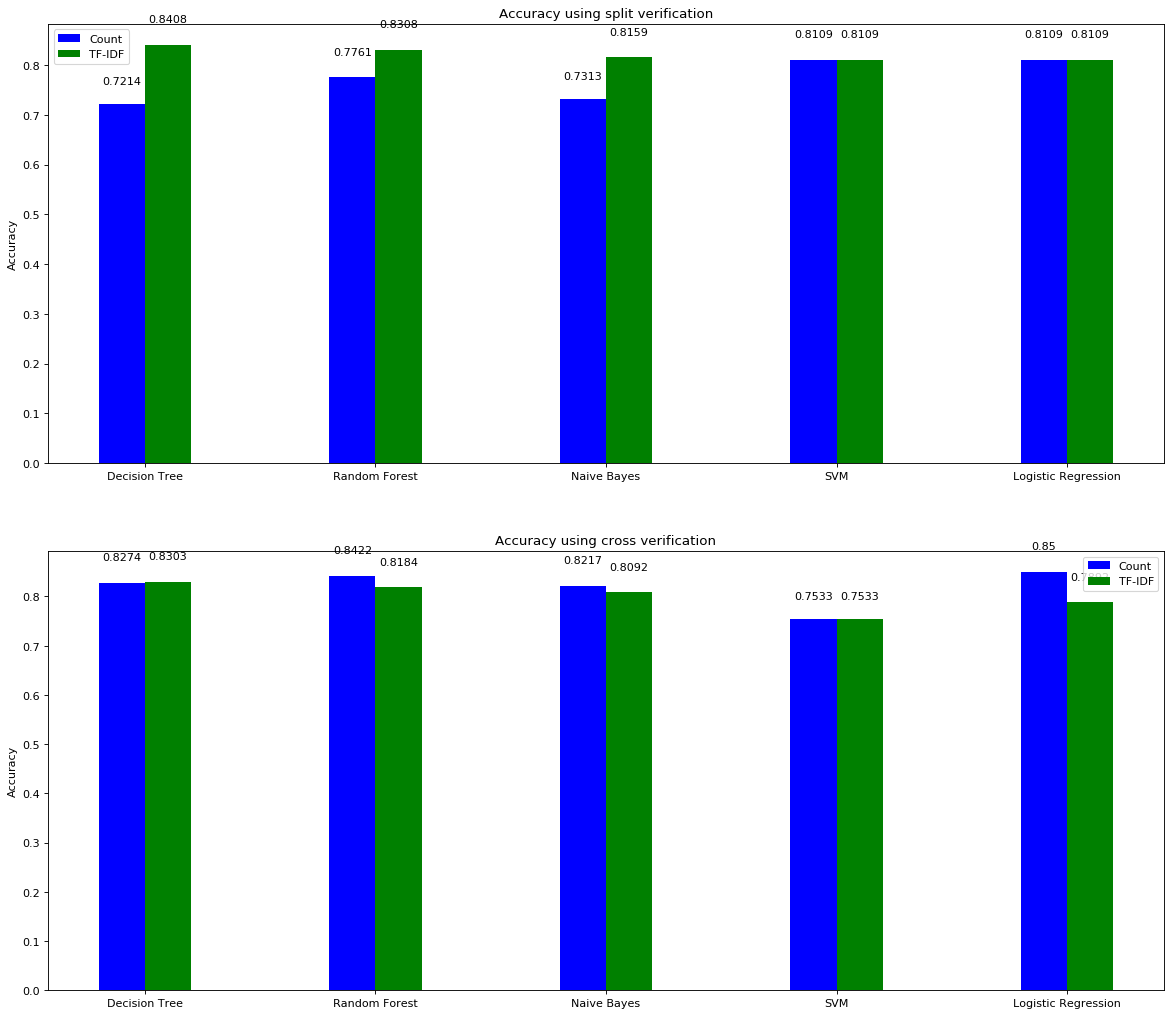

In [60]:
import warnings

warnings.filterwarnings("ignore")

data_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSGhxSbBeeXdkRdBVQ9wSL1aJTs52SXV3NKfcfoX1wI89XDCJMC5tW0HZk5HYdh2xT0DtufMLSn9hHX/pub?gid=1193567183&single=true&output=csv"
# data_url = 'file:///Users/nernst/Documents/projects/design-detect/minEval/data/brunet.csv'
data = process(data_url)

verify(data, 0.2, 10) ## data, test_size_for_split, k_fold_for_cross

In [ ]:
Ref: https://github.com/nadbordrozd/blog_stuff/blob/master/classification_w2v/benchmarking_python3.ipynb